In [1]:
def plot_sed(x, y, yerr):
    plt.clf()
    plt.errorbar(wavelength, flux, yerr=flux_err, c='red', ecolor='gray', capthick=2)
    plt.show()

# Libraries

In [2]:
# usual libraries ----------------------------------------------------------------------------------------------------
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import astropy.io.fits   as pf
import astropy.constants as ct
import os
import time
import scipy.interpolate as sci
import ipywidgets        as widgets

In [3]:
# ppxf separately ----------------------------------------------------------------------------------------------------
import ppxf.miles_util   as lib  # MILES library embedded in ppxf
import ppxf.ppxf_util    as util
import ppxf              as ppxf_module
from ppxf.ppxf           import ppxf
from ppxf.ppxf_util      import log_rebin

# Dataset

In [4]:
dataset_path = './../../Catalogue/Match08_smallemlines_inputcattype.csv'
my_data      = pd.read_csv(dataset_path)

In [5]:
whan_class = my_data['WHAN_CLASS'].values.astype(str)
uv_class   = my_data['UV_CLASS_YI2011'].values.astype(str)
cataid     = my_data['CATAID'].values.astype(str)
specid     = my_data['SPECID'].values.astype(str)
s2n        = my_data['S2N'].values.astype(float)
chi2_gama  = my_data['CHI2'].values.astype(float)
redshift   = my_data['Z'].values.astype(float)

In [6]:
uv_unique   = np.unique(uv_class, return_counts=True)
whan_unique = np.unique(whan_class, return_counts=True)
print (uv_unique, '\n', whan_unique)

(array(['RSF', 'UV_UPTURN', 'UV_WEAK'], dtype='<U9'), array([13840,   210,   296])) 
 (array(['Retired/Passive', 'SF', 'nan', 'sAGN', 'wAGN'], dtype='<U15'), array([ 876, 9408, 1285, 2184,  593]))


In [7]:
idx_uvup_rp = np.where((uv_class=='UV_UPTURN')*(whan_class=='Retired/Passive'))

## Plot the distributions of S/N

### Plot settings (yes, I'm lazy)

In [8]:
bins = 20
palette = ['#a6611a','#dfc27d','#80cdc1','#018571']
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.

### Histogram - S/N and $\chi^2$

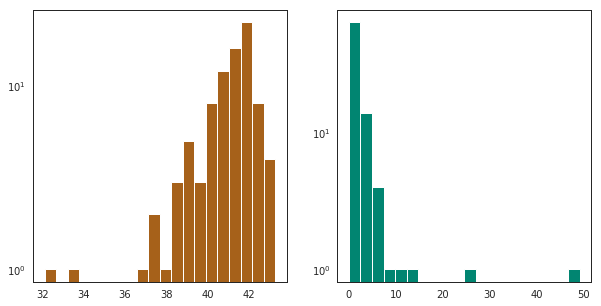

In [9]:
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(s2n[idx_uvup_rp], bins=bins, color=palette[0])
plt.yscale('log')
plt.subplot(1,2,2)
plt.hist(chi2_gama[idx_uvup_rp], bins=bins, color=palette[3])
plt.yscale('log')
plt.show()

### Selecting top 10 objects with the best S2N

In [10]:
best_s2n_10 = np.argsort(s2n[idx_uvup_rp])[-10:-1]

In [11]:
s2n_top10 = s2n[idx_uvup_rp][best_s2n_10]    # top 10 objects given the S/N

In [12]:
chi2_top   = chi2_gama[idx_uvup_rp][best_s2n_10]
specid_top = specid[idx_uvup_rp][best_s2n_10]

# pPXF

## Configuring inputs

In [13]:
ppxf_dir     = os.path.dirname(os.path.realpath(ppxf_module.__file__))
miles_lib    = ppxf_dir+'/miles_models/Mun1.30*.fits'
seds_path   = './../../../../GAMADR3_SPECTRA/DATABASE/'
results_path = './Results/'

light_speed  = float(str(ct.c.to('km/s')).split(' ')[0])            # selecting the numerical values (must be in km/s)

In [14]:
seds_list = []
for i in specid_top: seds_list.append(i+'.fit')

In [15]:
bar = widgets.IntProgress(value=1, min=1, max=len(seds_list), step=1, description='Running pPXF:',
                          orientation='horizontal')
display(bar)

IntProgress(value=1, description='Running pPXF:', max=9, min=1)

### pPXF plot settings

In [16]:
palette      = ['#ef8a62','#f7f7f7','#67a9cf']
transparency = 0.8
lw           = 2.

## pPXF settings

In [17]:
# Fit (V, sig, h3, h4) moments=4 for the stars; (V, sig) moments=2 for the two gas kinematic components
moments        = [4, 2, 2]
degree         = -1         # Additive Legendre polynomial degrees
mdegree        = 120        # Multiplicative Legendre polynomial degrees
regul_err      = 0.013      # Desired regularization error -- TODO: MUST CHECK WHY 0.013
tied_balmer    = True
limit_doublets = False
stellar_comp_w = [0]        # weight of the stellar component
balmer_comp_w  = [1]        # weight of the balmer emission lines
forbid_comp_w  = [2]        # weight of the forbidden lines
# wl_min         = 3540       # MILES RANGE MIN
# wl_max         = 7409       # MILES RANGE MAX
wl_min = 4300               # removinf the bluest part of the spectra in order to mitigate noise effects
wl_max = 7409

In [18]:
mean_age   = ['<logAge>']
mean_metal = ['<[M/H]>']
mass2light = ['MASS2LIGHT_R']
ids        = ['CATAID']
redshifts  = ['Z']

/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     51800      1000     0.300     0.300
 comp. 1:     50235       216
 comp. 2:     49800       180
chi2/DOF: 0.006126
method = capfit ; Jac calls: 8 ; Func calls: 1043 ; Status: 2
Gas Reddening E(B-V): 4.875
Nonzero Templates:  59  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown          0       2.7   50235   216
Comp: 2       Unknown          0       6.9   49800   180
Comp: 2       Unknown          0       7.2   49800   180
Comp: 2       Unknown          0       4.8   49800   180
---------------------------------------------------------
Weighted <logAge> [yr]: 9.93
Weighted <[M/H]>: -0.195
Weighted <logAge> [yr]: 9.93
Weighted <[M/H]>: -0.195
M/L_r: 3.52
Current $\chi^2$: 0.0061
Elap

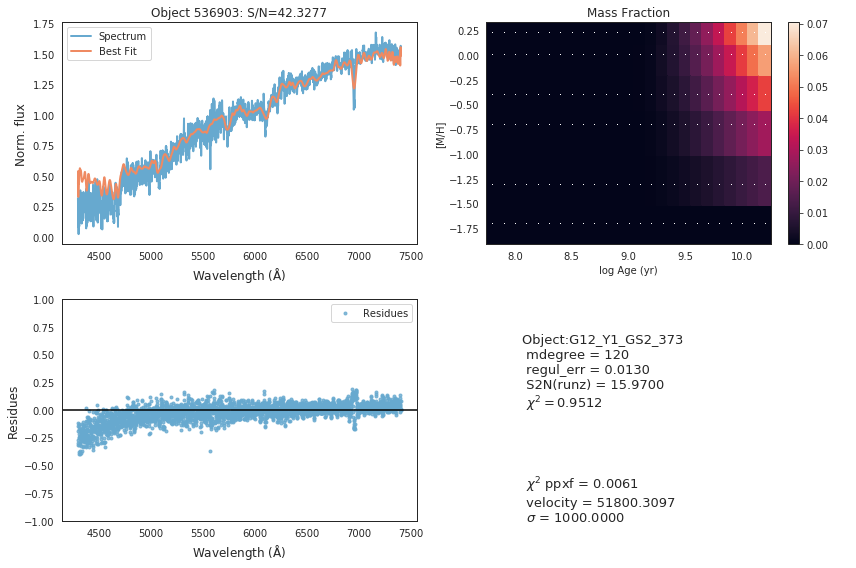

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     57708      1000    -0.018    -0.079
 comp. 1:     57793       157
 comp. 2:     56857       222
chi2/DOF: 0.004089
method = capfit ; Jac calls: 27 ; Func calls: 3517 ; Status: 2
Gas Reddening E(B-V): 0.726
Nonzero Templates:  109  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      3.133       3.9   57793   157
Comp: 2       Unknown          0       7.5   56857   222
Comp: 2       Unknown          0       7.5   56857   222
Comp: 2       Unknown    0.05865       6.6   56857   222
---------------------------------------------------------
Weighted <logAge> [yr]: 9.79
Weighted <[M/H]>: -0.358
Weighted <logAge> [yr]: 9.79
Weighted <[M/H]>: -0.358
M/L_r: 2.227
Current $\chi^2$: 0.0041
E

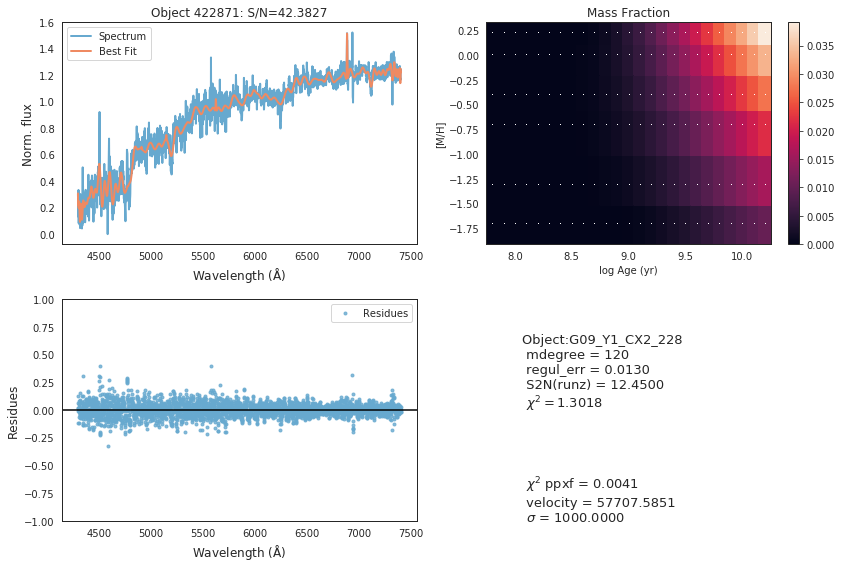

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     51321       754    -0.046     0.033
 comp. 1:     51775       929
 comp. 2:     51945         1
chi2/DOF: 0.01535
method = capfit ; Jac calls: 12 ; Func calls: 1566 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  136  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      15.21       7.1   51775   929
Comp: 2       Unknown     0.3731       5.6   51945     1
Comp: 2       Unknown      3.261       5.7   51945     1
Comp: 2       Unknown     0.2095       3.1   51945     1
---------------------------------------------------------
Weighted <logAge> [yr]: 9.8
Weighted <[M/H]>: -0.802
Weighted <logAge> [yr]: 9.8
Weighted <[M/H]>: -0.802
M/L_r: 1.791
Current $\chi^2$: 0.0154
Elap

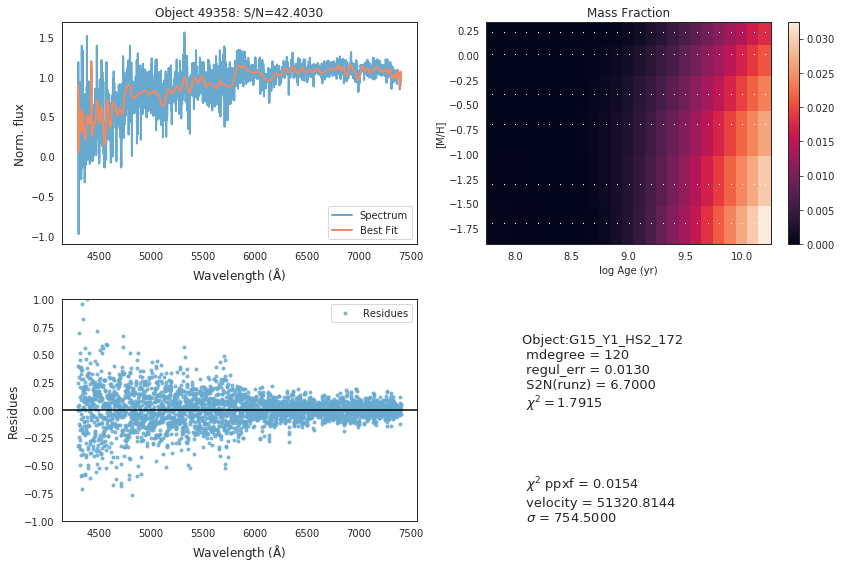

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     69558      1000     0.000     0.156
 comp. 1:     69725       303
 comp. 2:     69716       430
chi2/DOF: 0.006281
method = capfit ; Jac calls: 11 ; Func calls: 1435 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  73  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      1.514       6.8   69725   303
Comp: 2       Unknown          0        17   69716   430
Comp: 2       Unknown          0        17   69716   430
Comp: 2       Unknown      2.109       4.9   69716   430
---------------------------------------------------------
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
M/L_r: 3.086
Current $\chi^2$: 0.0063
El

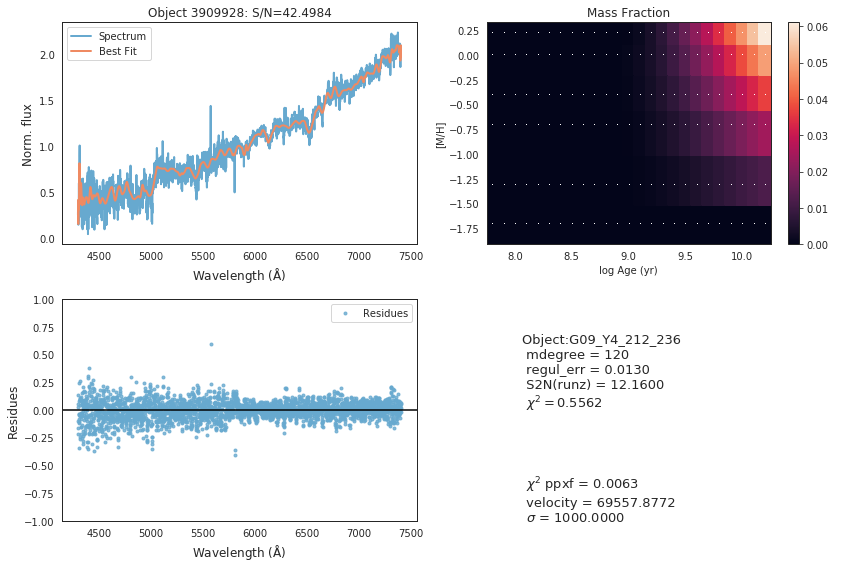

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     54989      1000     0.004     0.017
 comp. 1:     54417       373
 comp. 2:     55457       202
chi2/DOF: 0.008723
method = capfit ; Jac calls: 14 ; Func calls: 1824 ; Status: 2
Gas Reddening E(B-V): 3.505
Nonzero Templates:  101  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      1.915       3.4   54417   373
Comp: 2       Unknown          0       7.7   55457   202
Comp: 2       Unknown      4.416       7.8   55457   202
Comp: 2       Unknown      1.481       7.1   55457   202
---------------------------------------------------------
Weighted <logAge> [yr]: 9.81
Weighted <[M/H]>: -0.257
Weighted <logAge> [yr]: 9.81
Weighted <[M/H]>: -0.257
M/L_r: 2.454
Current $\chi^2$: 0.0087
E

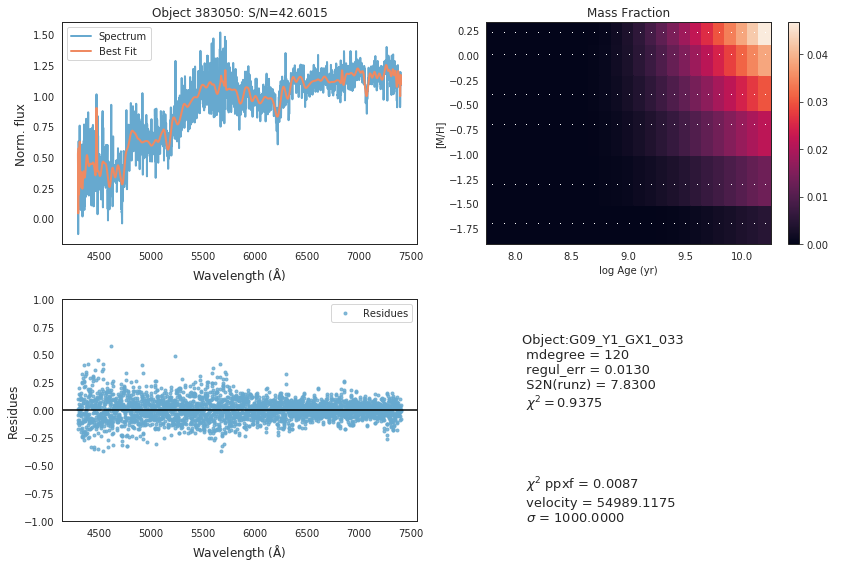

Emission lines included in gas templates:
['Balmer' '[OII]3729' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     43455      1000    -0.038    -0.127
 comp. 1:     42979         1
 comp. 2:     42968         1
chi2/DOF: 0.002511
method = capfit ; Jac calls: 15 ; Func calls: 1953 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  138  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.1191       2.2   42979     1
Comp: 2       Unknown      2.083       4.5   42968     1
Comp: 2       Unknown          0       2.7   42968     1
Comp: 2       Unknown     0.1288       1.5   42968     1
---------------------------------------------------------
Weighted <logAge> [yr]: 9.79
Weighted <[M/H]>: -0.633
Weighted <logAge> [yr]: 9.79
Weighted <[M/H]>: -0.633
M/L_r: 1.909
Current $\chi^2$: 0.0025


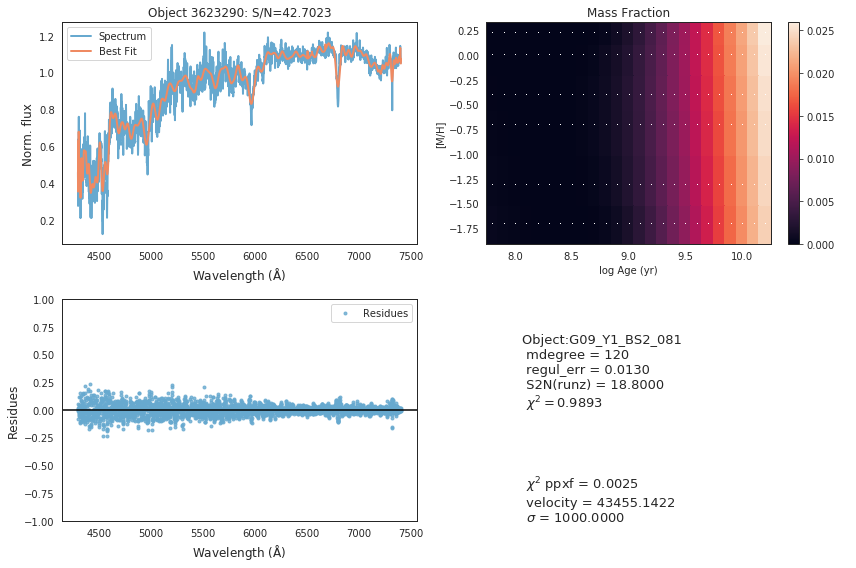

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     49680      1000     0.300     0.300
 comp. 1:     47546         1
 comp. 2:     46384      1000
chi2/DOF: 0.02126
method = capfit ; Jac calls: 14 ; Func calls: 1832 ; Status: 2
Gas Reddening E(B-V): 10.000
Nonzero Templates:  60  /  155
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown    0.09537       1.9   47546     1
Comp: 2       Unknown      11.65   1.7e+02   46384  1000
Comp: 2       Unknown          0   1.7e+02   46384  1000
Comp: 2       Unknown          0       8.8   46384  1000
Comp: 2       Unknown      16.99       8.8   46384  1000
---------------------------------------------------------
Weighted <logAge> [yr]: 9.95
Weighted <[M/H]>: -0.195
Weighted <logAge> [yr]: 

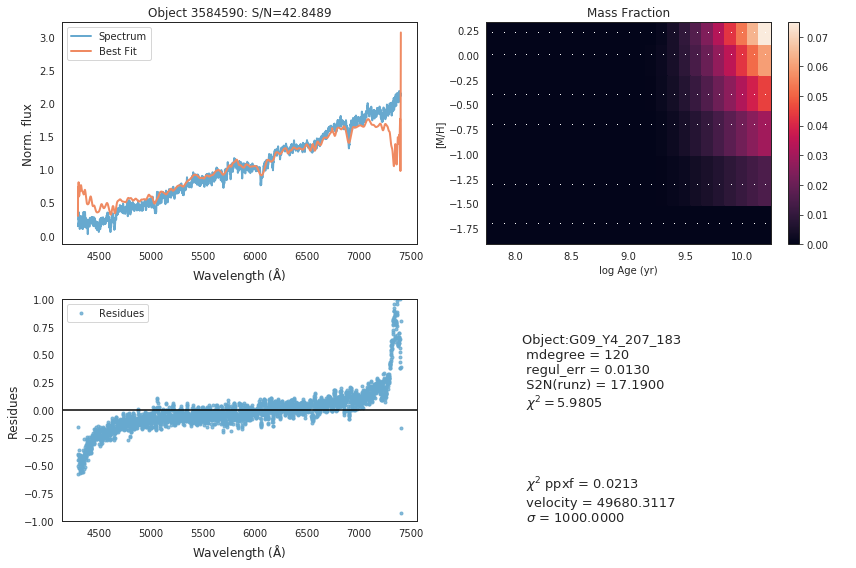

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     59357       942    -0.014     0.105
 comp. 1:     59436      1000
 comp. 2:     58932         1
chi2/DOF: 0.01694
method = capfit ; Jac calls: 12 ; Func calls: 1565 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  147  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      12.37        10   59436  1000
Comp: 2       Unknown          0       3.8   58932     1
Comp: 2       Unknown          0       3.8   58932     1
Comp: 2       Unknown          0       2.7   58932     1
---------------------------------------------------------
Weighted <logAge> [yr]: 9.66
Weighted <[M/H]>: -0.23
Weighted <logAge> [yr]: 9.66
Weighted <[M/H]>: -0.23
M/L_r: 1.428
Current $\chi^2$: 0.0169
Elap

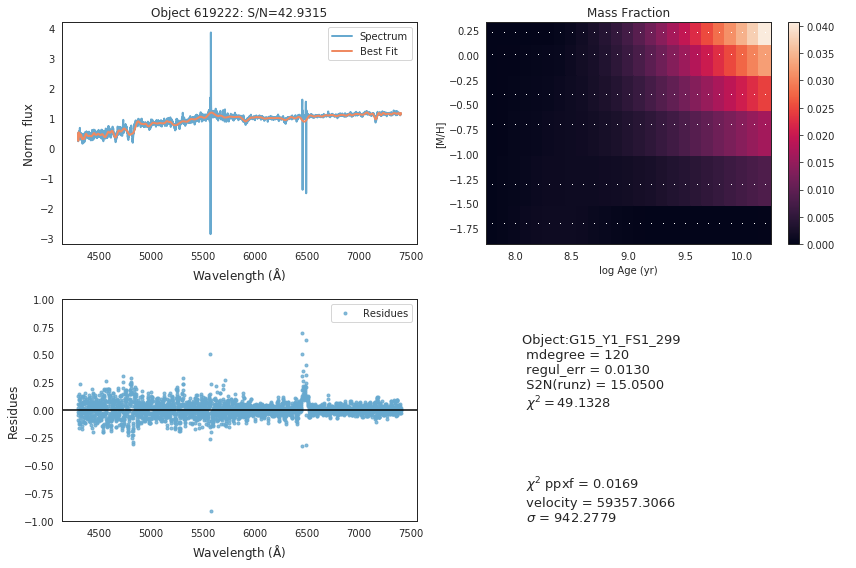

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     52795       578    -0.007     0.107
 comp. 1:     53397       630
 comp. 2:     52936       202
chi2/DOF: 0.002523
method = capfit ; Jac calls: 11 ; Func calls: 1434 ; Status: 2
Gas Reddening E(B-V): 0.449
Nonzero Templates:  91  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      1.406       7.8   53397   630
Comp: 2       Unknown          0       6.5   52936   202
Comp: 2       Unknown     0.4288       6.4   52936   202
Comp: 2       Unknown      1.605       6.3   52936   202
---------------------------------------------------------
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.203
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.203
M/L_r: 2.692
Current $\chi^2$: 0.0025
El

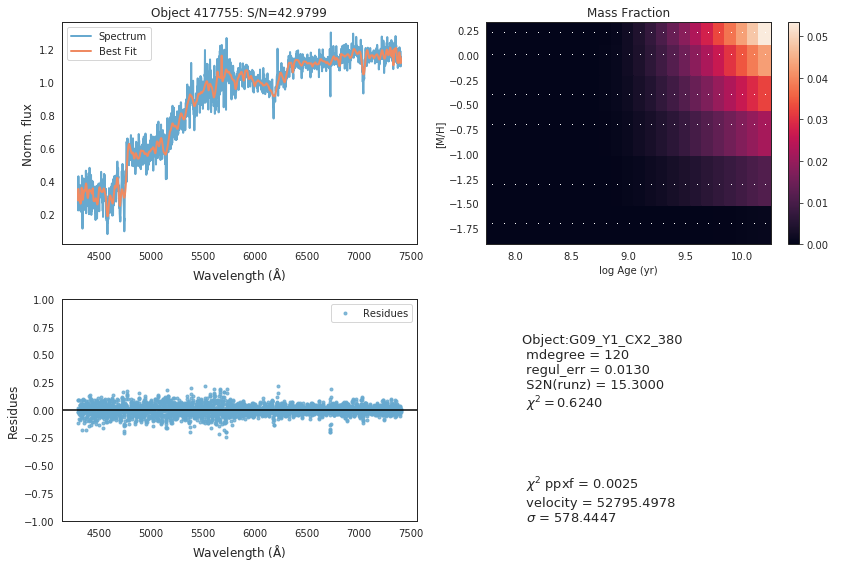

In [20]:
for each_sed in range(len(seds_list)):
# for each_sed in range(1):
    bar.value += each_sed # signal to increment the progress bar
#     bar.bar_style = '' if each_sed<(len(seds_list)) else bar.bar_style = 'success'
    # flux -----------------------------------------------------------------------------------------------------------
    sed_file  = os.path.join(seds_path, seds_list[each_sed])          # link between path and files
    sed_flux  = pf.getdata(sed_file)[0]                               # opening each spectra
    sed_err   = pf.getdata(sed_file)[1]                               # opening each spectra error
    
    # wavelength -----------------------------------------------------------------------------------------------------
    sed_header = pf.open(sed_file)[0].header
    sed_wl_ini = sed_header['WMIN'] 
    sed_wl_stp = sed_header['CD1_1']
    sed_wl     = np.arange(sed_flux.size)*(sed_wl_stp)+sed_wl_ini     # sed wavelength
    
#     plot_sed(sed_wl, sed_flux, sed_err)
    
    # cleaning flux and wavelength trash -----------------------------------------------------------------------------
    idx_clean       = np.where((np.logical_not(np.isnan(sed_flux)))*(sed_err>0))    # indices where NAN is present
    flux_temp       = sed_flux[idx_clean]                                           # removing NAN values from spectra
    flux_temp_err   = sed_err[idx_clean]
    wavelength_temp = sed_wl[idx_clean]
    
#     plot_sed(wavelength_temp, flux_temp, flux_temp_err)
    
    # limiting the spectrum regarding the wavelength range of the library --------------------------------------------
    wl_lib_idx = (wavelength_temp>wl_min) & (wavelength_temp<wl_max)       # MILES wavelength range
    flux       = flux_temp[wl_lib_idx]
    flux_err   = flux_temp_err[wl_lib_idx]
    wavelength = wavelength_temp[wl_lib_idx]
    
#     plot_sed(wavelength, flux, flux_err)    
    
    # other important parameters -------------------------------------------------------------------------------------
    redshift  = sed_header['Z']
    cataid    = sed_header['CATAID']
    fwhm_gama = 3.
    
    # ppxf -----------------------------------------------------------------------------------------------------------
    vel_scale          = light_speed*np.log(wavelength[1]/wavelength[0])      # velocity scale - Eq.8 Capellari 2017
    
    ### setup templates ----------------------------------------------------------------------------------------------
    #### stellar pops ------------------------------------------------------------------------------------------------
    miles              = lib.miles(miles_lib, vel_scale, fwhm_gama)
    stellar_templates  = miles.templates.reshape(miles.templates.shape[0], -1)
    reg_dim            = miles.templates.shape[1:]
    dv                 = light_speed*(miles.log_lam_temp[0] - np.log(wavelength[0]))  # eq.(8) of Cappellari (2017)
    vel                = light_speed*np.log(1 + redshift)                             # eq.(8) of Cappellari (2017)
    start              = [vel, 180.]
    
    #### gas templates -----------------------------------------------------------------------------------------------
    wl_range_galaxy = np.array([np.min(wavelength), np.max(wavelength)])/(1 + redshift)
    gas_templates, gas_names, line_wave = util.emission_lines(miles.log_lam_temp, wl_range_galaxy, fwhm_gama, 
                                                              tie_balmer=tied_balmer, limit_doublets=limit_doublets)
    number_of_templates = stellar_templates.shape[1]
    number_of_forbidden = np.sum(["[" in a for a in gas_names])                      # forbidden lines contain "[*]"
    number_of_balmer    = len(gas_names) - number_of_forbidden
        
    component = (stellar_comp_w*number_of_templates)+(balmer_comp_w*number_of_balmer)+(forbid_comp_w
                                                                                       *number_of_forbidden)
        
    gas_component = np.array(component) > 0       # gas_component=True for gas templates
    start3        = [start, start, start]         # adopt the same starting value for the 3 components
    gas_reddening = 0 if tied_balmer else None    # If the Balmer lines are tied one should allow for gas reddening.
    
    
    #### all templates -----------------------------------------------------------------------------------------------
    all_templates = np.column_stack([stellar_templates, gas_templates])
    
    ### rebinning the spectrum so it is at the same size as the templates (or smaller) -------------------------------
    new_shape          = stellar_templates[:,0].shape
    rebinning_function = sci.interp1d(wavelength, flux)   # for the flux
    wavelength_rebin   = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_rebin         = rebinning_function(wavelength_rebin)
    
    ### rebinning the error ------------------------------------------------------------------------------------------
    rebin_func_error   = sci.interp1d(wavelength, flux_err)
    wl_rebin_error     = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_err_rebin     = rebin_func_error(wavelength_rebin)
    
    ### final galaxy spectrum and its error to be analysed -----------------------------------------------------------
    galaxy             = flux_rebin/np.median(flux_rebin)               # Normalize spectrum to avoid numerical issues
    noise              = flux_err_rebin/np.median(flux_err_rebin)       # idem
    
#     plot_sed(wavelength_rebin, galaxy, noise)    
    
    ### SED FITTING WITH PPXF ----------------------------------------------------------------------------------------
    start_time = time.clock()
    sed_fit = ppxf(templates=all_templates, galaxy=galaxy, noise=noise, velscale=vel_scale, start=start3, plot=False, 
                   lam=wavelength_rebin, moments=moments, degree=degree, mdegree=mdegree, regul=1./regul_err, 
                   reg_dim=reg_dim, vsyst=dv, clean=False, component=component, gas_component=gas_component,
                   gas_reddening=gas_reddening)
    end_time = time.clock()
    
    ## output parameters -- most of them will become a dataframe at the end of the script  
    residues = (galaxy-sed_fit.bestfit)
    
    stellar_weights = sed_fit.weights[~gas_component]                         # Exclude weights of the gas templates
    stellar_weights = stellar_weights.reshape(reg_dim)/stellar_weights.sum()  # Normalized
    
    velocity = sed_fit.sol[0][0]
    sigma    = sed_fit.sol[0][1]
    
    mean_age.append(miles.mean_age_metal(stellar_weights)[0])
    mean_metal.append(miles.mean_age_metal(stellar_weights)[1])
    mass2light.append(miles.mass_to_light(stellar_weights, band="r"))
    ids.append(cataid)
    redshifts.append(redshift)
       
    print(r"Current $\chi^2$: %.4f" % (sed_fit.chi2))
    print('Elapsed time in PPXF: %.2f [min]' % ((end_time-start_time)/60))
    
    ### Saving fit results -------------------------------------------------------------------------------------------
    output = {}
    output['wavelength'] = wavelength_rebin
    output['flux']       = sed_fit.galaxy
    output['best_fit']   = sed_fit.bestfit
    
    output_df = pd.DataFrame(output)
    output_df.to_csv(os.path.join('./Results/', 'fit_'+str(cataid)+'_'+str(mdegree)+str(wl_min)+'.csv'), index=False)

    ### Saving plots -------------------------------------------------------------------------------------------------
    plt.subplots(figsize=(12,8))
    
    #### plot01 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,1)
    plt.plot(wavelength_rebin, sed_fit.galaxy, '-', color=palette[-1], linewidth=lw, label="Spectrum")
    plt.plot(wavelength_rebin, sed_fit.bestfit, '-', color=palette[0], linewidth=lw, label="Best Fit")
    plt.title("Object %s: S/N=%.4f" % (cataid, s2n_top10[each_sed]))
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Norm. flux", fontsize=12)
    
    #### plot02 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,2)
    miles.plot(stellar_weights)
    
    #### plot03 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,3)
    plt.plot(wavelength_rebin, residues, '.', color=palette[-1], linewidth=lw, label="Residues", alpha=transparency)
    plt.axhline(y=0, c='black')
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Residues", fontsize=12)
    plt.ylim([-1,1])
    
    #### plot04 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,4)
    plt.text(0.1, 0.5, "Object:{:s} \n mdegree = {:d} \n regul_err = {:.4f}\n S2N(runz) = {:.4f} \n $\chi^2 = ${:.4f}"
             .format(sed_header['SPECID'], mdegree, regul_err, sed_header['SN'], chi2_top[each_sed]), 
             fontsize=13)
    plt.text(0.1, 0.0, " \n $\chi^2$ ppxf = {:.4f} \n velocity = {:.4f} \n $\sigma$ = {:.4f}"
             .format(sed_fit.chi2, velocity, sigma), fontsize=13)
    plt.axis('off') 
    
    plt.tight_layout()
    plt.savefig(os.path.join('./Results/', 'gal_'+str(cataid)+'_'+str(mdegree)+'_'+str(wl_min)+'.png'))
    plt.show()

In [21]:
### Saving outputs as dataframe ----------------------------------------------------------------------------------
ids        = np.array(ids)
redshifts  = np.array(redshifts)
mean_age   = np.array(mean_age)
mean_metal = np.array(mean_metal)
mass2light = np.array(mass2light)
outputs    = np.column_stack((ids, redshifts, mean_age, mean_metal, mass2light))
columns    = outputs[0,:]
outputs_dataframe = pd.DataFrame(outputs[1:,:])
outputs_dataframe.columns = columns
outputs_dataframe.to_csv('./Results/'+'ouputs_ppxf_'+str(mdegree)+'_'+str(wl_min)+'.csv', index=False)